# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -q smdebug

In [17]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import os
import boto3
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

s3 = boto3.client("s3")

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip -q dogImages.zip
!rm dogImages.zip

--2024-11-19 12:25:47--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.160, 52.219.112.72, 52.219.121.96, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.160|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.5MB/s    in 25s     

2024-11-19 12:26:12 (43.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



## Upload to S3

In [5]:
s3_bucket = "udacity-deeplearning-project"
s3_data_destination = f"s3://{s3_bucket}/data/"

# Collect all files to upload
files_to_upload = []
for root, dirs, files in os.walk("dogImages"):
    for file in files:
        files_to_upload.append(os.path.join(root, file))

# Upload all images to s3 with progress bar
for file in tqdm(files_to_upload, desc="Uploading files to s3"):
    s3_prefix = f"data/{file}".replace("dogImages/", "")
    s3.upload_file(file, s3_bucket, s3_prefix)

Uploading files to s3: 100%|██████████| 8351/8351 [00:00<00:00, 1778272.46it/s]


## Inspect Class Inbalance

In [20]:
image_list = []
for file_path in files_to_upload:
    split_file_path = file_path.split("/")
    label_numeric = split_file_path[-2].split('.')[0]
    processing_type = split_file_path[1]
    image_description = split_file_path[-2].split('.')[1]
    image_list.append([label_numeric, processing_type, image_description])

dog_breeds_df = pd.DataFrame(image_list, columns=["label_numeric", "processing_type", "dog_breed"])
dog_breeds_group_df = dog_breeds_df.groupby(["label_numeric", "processing_type", "dog_breed"], as_index=False).size().sort_values("size", ascending=False)

In [21]:
!pip install -q seaborn

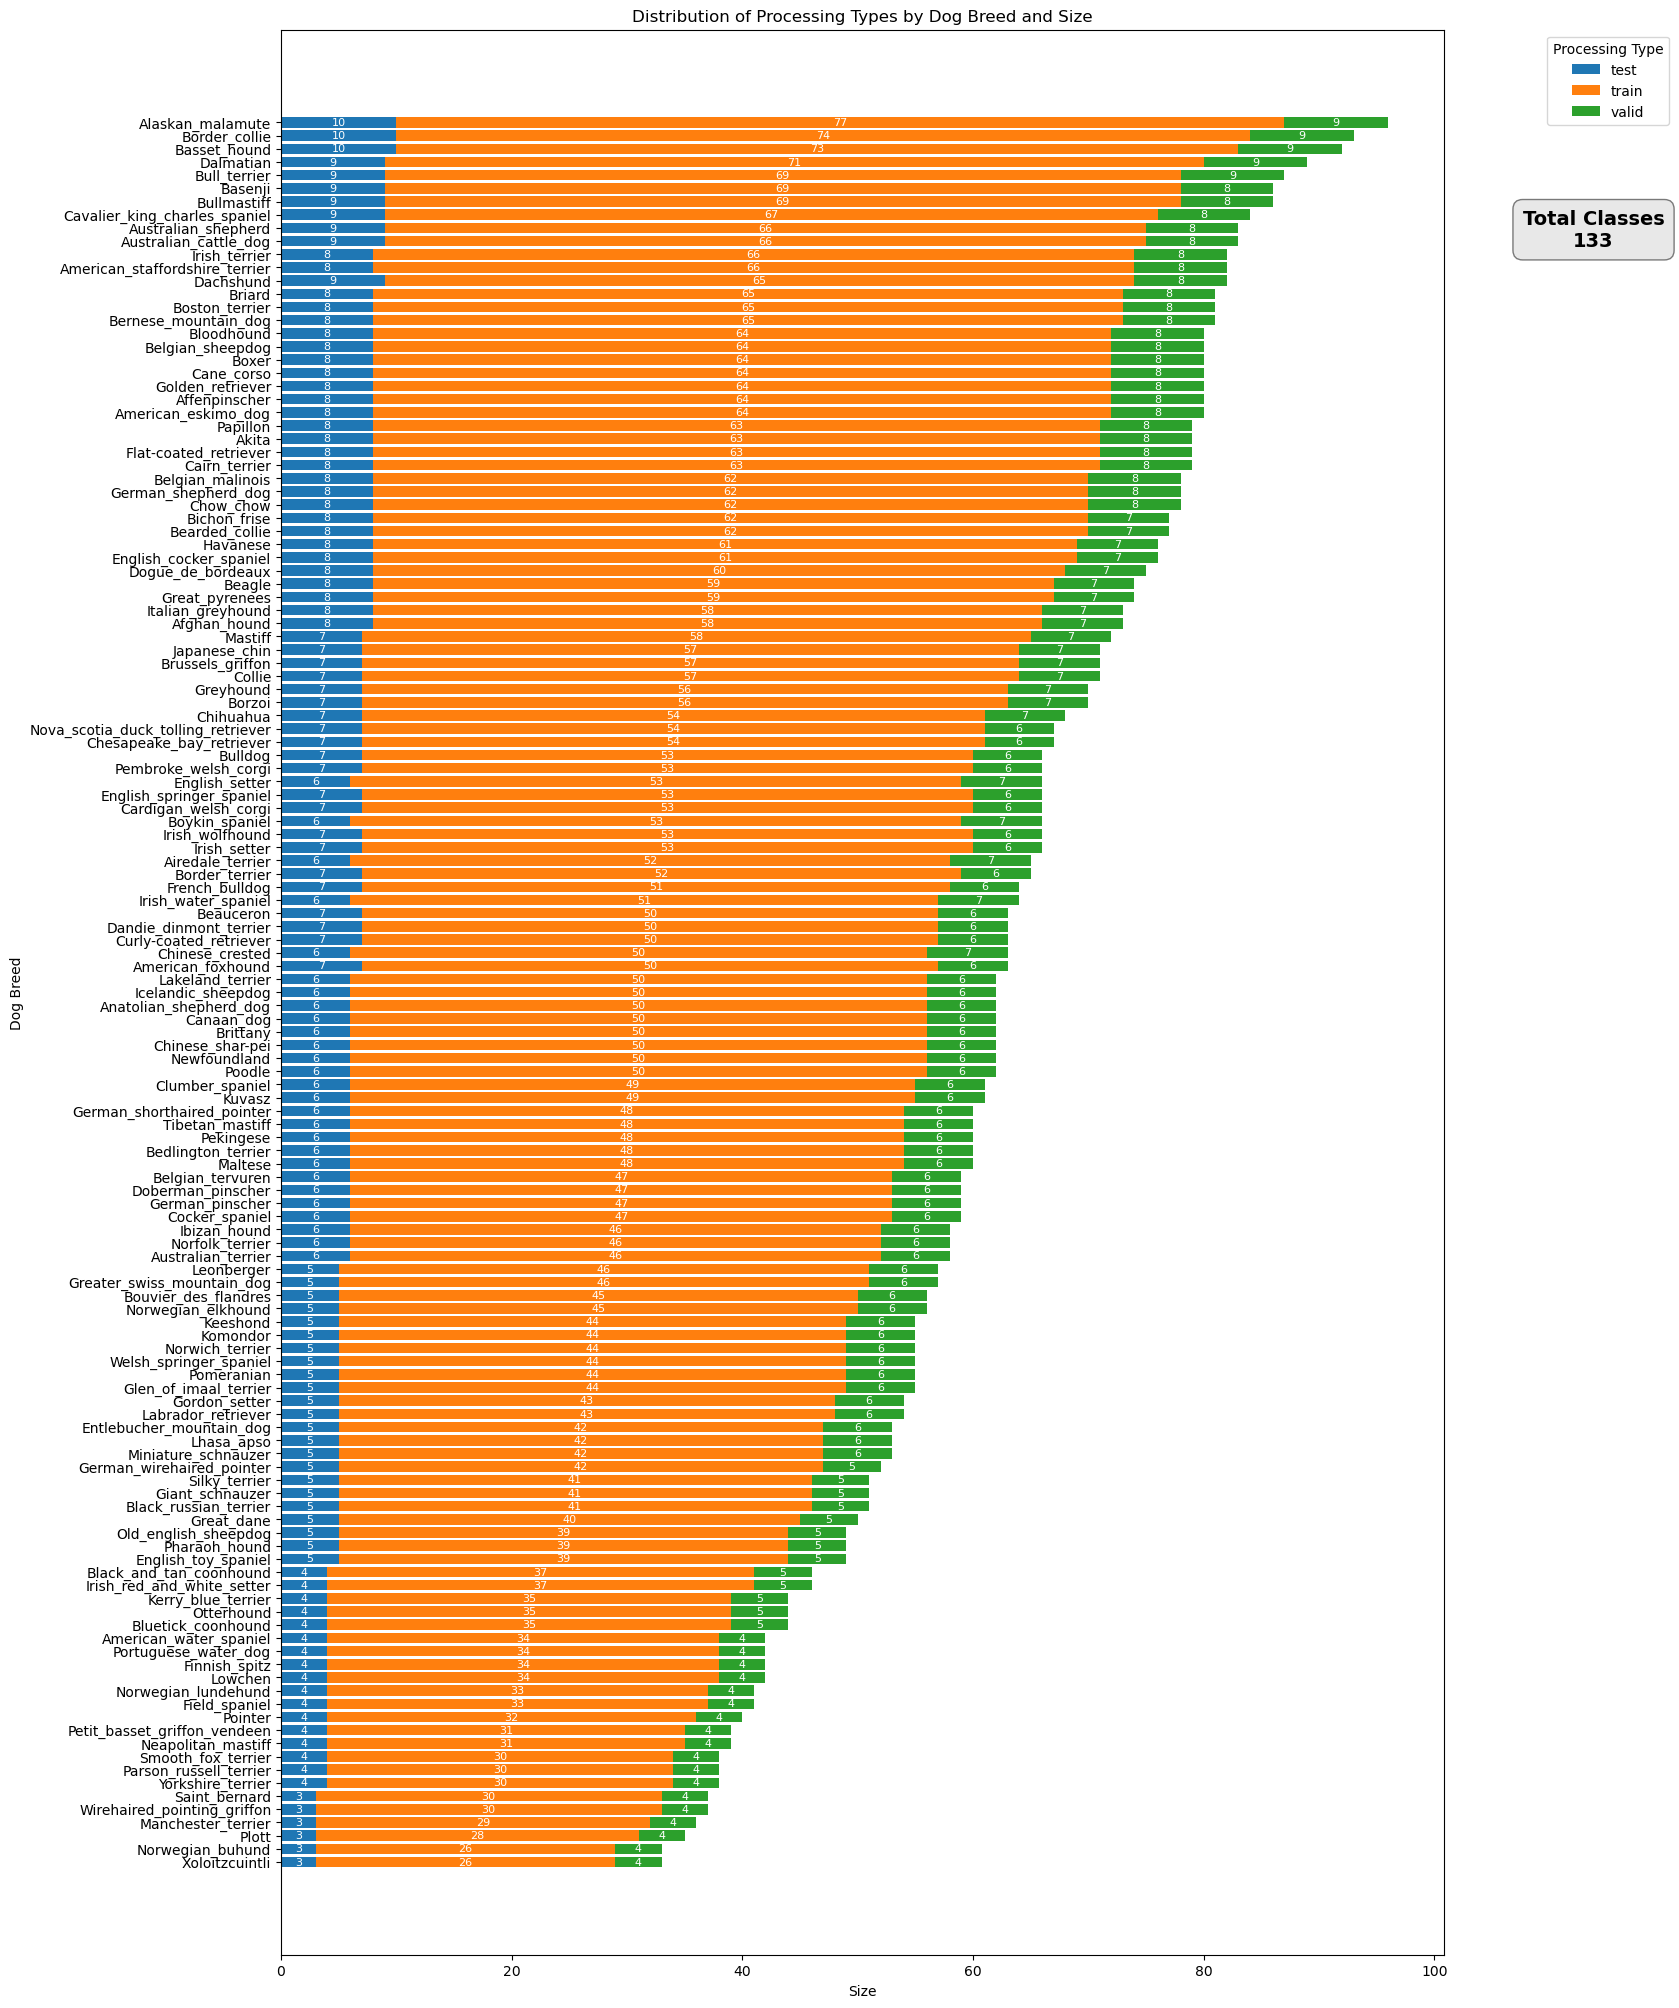

In [22]:
# Ignore all warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(15, 25))  # Increase the figure size for both plots

# Group and pivot the data for stacking
grouped_df = dog_breeds_group_df.groupby(["dog_breed", "processing_type"])["size"].sum().reset_index()
pivot_df = grouped_df.pivot(index="dog_breed", columns="processing_type", values="size").fillna(0)
pivot_df = pivot_df.assign(sorter=pivot_df.sum(axis=1)).sort_values("sorter", ascending=True).drop(columns=["sorter"])

# GRAPH ONE
# Calculate cumulative sums for stacking
bottoms = np.zeros(len(pivot_df))

# Plot each processing type as a separate bar
for processing_type in pivot_df.columns:
    ax.barh(pivot_df.index, pivot_df[processing_type], left=bottoms, label=processing_type)

     # Add annotations to each bar segment
    for i, value in enumerate(pivot_df[processing_type]):
        if value > 0:  # Only annotate if value is greater than 0
            ax.text(bottoms[i] + value / 2, i, str(int(value)), va='center', ha='center', fontsize=8, color='white')
        
    bottoms += pivot_df[processing_type]  # Update left position for next bar

# Customize the plot
ax.set_ylabel("Dog Breed")
ax.set_xlabel("Size")
ax.set_title("Distribution of Processing Types by Dog Breed and Size")
ax.legend(title="Processing Type", loc="upper right", bbox_to_anchor=(1.2, 1))


# GRAPH TWO
ax2 = fig.add_axes([0.85, 0.2, 0.1, 0.6])  # [left, bottom, width, height]
ax2.axis("off")  # Turn off the axis

# Display the total count as a card-like text
total_label_count = len(dog_breeds_group_df['label_numeric'].unique())
ax2.text(1.5, 1, f"Total Classes\n{total_label_count}", ha="center", va="center",
         fontsize=14, fontweight="bold", bbox=dict(facecolor="lightgray", alpha=0.5, boxstyle="round,pad=0.5"))

plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

#TODO: Create estimators for your HPs
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

role=get_execution_role()

estimator=Estimator(
    image_uri='598308907998.dkr.ecr.us-east-1.amazonaws.com/udacity-sagemaker-hpo',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type='ml.p3.2xlarge'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

# TODO: Fit your HP Tuner
bucket = 'udacity-deeplearning-project'
sample_prefix = 'sample'

model_inputs = model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/{sample_prefix}/data/train/",
        content_type="application/x-image"
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/{sample_prefix}/data/valid/",
        content_type="application/x-image"
    )
}

tuner.fit(inputs=model_inputs, wait=True) # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()